In [1]:
from __future__ import absolute_import, division, print_function

import pandas as pd
import numpy as np
import torch

# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Load traffic data of three days for the first time

'''
import glob
files = glob.glob("/content/drive/MyDrive/security_data/TrafficLabelling " + "/*.csv")

data_list = []
day_list = ['M_W','T_W','F_W']
all_data_length = 0

for file in files:
  print(file)
  data = pd.read_csv(file, encoding='cp1252')
  #useful_data = data[data[' Label'] != 'BENIGN']
  data_list.append(data)
  all_data_length += data.count()

df = pd.concat(data_list, axis=0, ignore_index=True)
'''

'\nimport glob\nfiles = glob.glob("/content/drive/MyDrive/security_data/TrafficLabelling " + "/*.csv")\n\ndata_list = []\nday_list = [\'M_W\',\'T_W\',\'F_W\']\nall_data_length = 0\n\nfor file in files:\n  print(file)\n  data = pd.read_csv(file, encoding=\'cp1252\')\n  #useful_data = data[data[\' Label\'] != \'BENIGN\']\n  data_list.append(data)\n  all_data_length += data.count()\n\ndf = pd.concat(data_list, axis=0, ignore_index=True)\n'

In [3]:
# Clean traffic data and divide data into two parts with flow type for the first time

'''
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
ab_df = df[df[' Label'] != 'BENIGN']
nor_df = df[df[' Label'] == 'BENIGN']
'''

In [5]:
# Average sampling the abnormal flows with different attack types for the first time

'''
IPs = ab_df[' Source IP'].unique()
data_list = []

for source in IPs:
  print(source)
  Data = ab_df[ab_df[' Source IP'] == source]
  L = len(Data)
  for i in range(0, int(L / 10)):
    n = 10
    locs = np.random.randint(0, L, n)
    #locs = np.unique(locs)[:n]
    #if len(temp_data) < n*10:
    #  locs = np.random.randint(0, len(temp_data), n)
    #assert len(locs) == n, "sample() assumes n << len(series)"
    s = Data.take(locs)
    data_list.append(s)

re_sampled_df = pd.concat(data_list, axis=0, ignore_index=True)
'''

'\nIPs = ab_df[\' Source IP\'].unique()\ndata_list = []\n\nfor source in IPs:\n  print(source)\n  Data = ab_df[ab_df[\' Source IP\'] == source]\n  L = len(Data)\n  for i in range(0, int(L / 10)):\n    n = 10\n    locs = np.random.randint(0, L, n)\n    #locs = np.unique(locs)[:n]\n    #if len(temp_data) < n*10:\n    #  locs = np.random.randint(0, len(temp_data), n)\n    #assert len(locs) == n, "sample() assumes n << len(series)"\n    s = Data.take(locs)\n    data_list.append(s)\n\nre_sampled_df = pd.concat(data_list, axis=0, ignore_index=True)\n'

In [6]:
# Store the abnormal sampled data into remote disk for the first time
#re_sampled_df.to_csv('/content/drive/MyDrive/security_data/resampled_ab_data.csv')

In [7]:
resampled_ab_df = pd.read_csv('/content/drive/MyDrive/security_data/resampled_ab_data.csv', encoding='cp1252')

In [8]:
# Average sampling the normal flows for the first time

'''
dataByNode = nor_df.groupby(' Source IP')
data_list = []

counter = 0

for node, group in dataByNode:
  loop_num = int(len(group) / 30)
  if(len(group) > 10 and loop_num > 0):
    for i in range(0, loop_num):
      start = np.random.randint(0, len(group) - 10)
      dataIndex = [i for i in range(start, start + 10)] 
      s = group.take(dataIndex)
      data_list.append(s)
      counter += 1

resampled_nor_df = pd.concat(data_list, axis=0, ignore_index=True)

resampled_nor_df.to_csv('/content/drive/MyDrive/security_data/resampled_nor_data.csv')
'''

resampled_nor_df = pd.read_csv('/content/drive/MyDrive/security_data/resampled_nor_data.csv')

In [9]:
#resampled_nor_df.to_csv('/content/drive/MyDrive/security_data/resampled_nor_data.csv')

In [10]:
# Data cleaning and dimension reduction

df = pd.concat([resampled_nor_df, resampled_ab_df])
df = df.drop(columns=[' Source IP', ' Destination IP', ' Timestamp', 'Flow ID', 'Unnamed: 0'])
def label_transfer(d):
  if d != 'BENIGN':
    return 1
  else:
    return 0

df = df.replace([np.inf, -np.inf], np.nan)

df = df.dropna()

1272320


In [13]:
# Convert flow label to 1/0 format

df[' Label'] = df[' Label'].apply(lambda x: label_transfer(x))

In [14]:
# Data standarlization and assemble

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
colunm_size = len(df.columns)
values = df.values[:, :colunm_size - 1]
scaler.fit(values)
values = scaler.transform(values)
targets = df.values[:, colunm_size - 1: colunm_size]

grouped_data_x = np.zeros((int(len(values) / 10), 10, 80))
grouped_data_y = np.zeros((int(len(targets) / 10)))
for i in range(0, len(values), 10):
  locs = np.arange(i, i + 10, 1)
  token_list = values[[locs]]
  grouped_data_x[int(i/10)] = token_list
  grouped_data_y[int(i/10)] = targets[i]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  from ipykernel import kernelapp as app


In [15]:
# Data split for traning and test

permutation = torch.randperm(len(grouped_data_x))
train_indices = list(permutation[0: int(len(grouped_data_x) * 0.8)])
test_indices = list(permutation[int(len(grouped_data_x) * 0.8): len(grouped_data_x)])

train_x = grouped_data_x[[train_indices]]
train_y = grouped_data_y[[train_indices]]

test_x = grouped_data_x[[test_indices]]
test_y = grouped_data_y[[test_indices]]

In [17]:
# Convert to tensor format

train_X = torch.from_numpy(train_x).type(torch.FloatTensor)
test_X = torch.from_numpy(test_x).type(torch.FloatTensor)

train_Y = torch.from_numpy(train_y).type(torch.LongTensor)
test_Y = torch.from_numpy(test_y).type(torch.LongTensor)

In [18]:
# Model structure

import math
import torch
import torch.nn as nn

class TransformerClassifier(nn.Module):

  def __init__(self, ninp, nhead, nhid, nlayers, dropout=0.5):
    super(TransformerClassifier, self).__init__()
    from torch.nn import TransformerEncoder, TransformerEncoderLayer
    self.model_type = 'Transformer'
    encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
    self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
    self.ninp = ninp
    self.dropout = nn.Dropout(0.3)
    self.convs = nn.ModuleList([nn.Conv2d(1, 100, (K, ninp)) for K in [3,4,5]])
    self.classifier = nn.Linear(ninp, 2)
    self.fc1 = nn.Linear(len([3,4,5]) * 100, 2)
    self.init_weights()
    

  def generate_square_subsequent_mask(self, sz):
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

  def init_weights(self):
    initrange = 0.1
    self.classifier.bias.data.zero_()
    self.classifier.weight.data.uniform_(-initrange, initrange)

  def forward2(self, src):
    # Transformer Layer
    src = src * math.sqrt(self.ninp)
    x = self.transformer_encoder(src)
    # Conv Layer
    x = x.unsqueeze(1)  # (N, Ci, W, D)
    x = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]  # [(N, Co, W), ...] * len(Ks)
    # Pooling Layer
    x = [torch.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(N, Co), ...] * len(Ks)
    x = torch.cat(x, 1)
    # Fully Connected Layer
    x = self.dropout(x)  # (N, len(Ks)*Co)
    logit = self.fc1(x)  # (N, C)
    return logit

  def forward(self, src):
    
    # Non-conv Approch
    src = src * math.sqrt(self.ninp)
    output = self.transformer_encoder(src)

    # Average Pooling Layer
    output = output.permute(0,2,1)
    output = torch.mean(output, -1)
    output = self.dropout(output)
    output = torch.relu(self.dense(output))
    output = self.dropout(output)
    output = self.classifier(output)
    return output

  def predict(self, x):

    #Apply sigmoid to output. 
    pred = torch.sigmoid(self.forward2(x))
    ans = []
    
    #Pick the class with maximum weight
    for t in pred:
      if t[0] > t[1]:
        ans.append(0)
      else:
        ans.append(1)
    return torch.tensor(ans)

In [19]:
import torch.optim

#Initialize the model        
model = TransformerClassifier(len(df.columns) - 1, 4, 1024, 3)
#Define loss criterion
criterion = nn.CrossEntropyLoss()
#Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [20]:
#Size of traning data batch

BATCH_SIZE = 512

#Number of epochs
epochs = 10
#List to store losses
losses = []
test_losses = []

for i in range(epochs):
  
  loss_total = 0
  test_lost_total = 0

  permutation = torch.randperm(train_X.size()[0])
  for j in range(0, train_X.size()[0], BATCH_SIZE):

    #Clear the previous gradients
    optimizer.zero_grad()

    #Batch the data
    indices = permutation[j: j + BATCH_SIZE]
    batch_x, batch_y = train_X[indices], train_Y[indices]

    train_y_pred = model.forward2(batch_x)
    test_y_pred = model.forward2(test_X[0:100])

    #Compute Cross entropy loss
    loss = criterion(train_y_pred, batch_y)
    loss_total += loss
    test_lost = criterion(test_y_pred, test_Y[0:100])
    test_lost_total += test_lost

    #Add loss to the list
    losses.append(loss.item())
    test_losses.append(test_lost.item())
    
    loss.backward()
    optimizer.step()

  print(str(i) + 'th of ' + str(epochs) + ' Epoch' + " | LOSS:" + str(loss_total.data) + " | T-LOSS:" + str(test_lost_total.data))


0th of 10 Epoch | LOSS:tensor(13.3178) | T-LOSS:tensor(11.6917)
1th of 10 Epoch | LOSS:tensor(3.7658) | T-LOSS:tensor(2.7254)
2th of 10 Epoch | LOSS:tensor(3.5895) | T-LOSS:tensor(2.4531)
3th of 10 Epoch | LOSS:tensor(2.5271) | T-LOSS:tensor(1.7438)
4th of 10 Epoch | LOSS:tensor(2.5927) | T-LOSS:tensor(1.3984)
5th of 10 Epoch | LOSS:tensor(1.7407) | T-LOSS:tensor(1.0109)
6th of 10 Epoch | LOSS:tensor(1.4189) | T-LOSS:tensor(1.0807)
7th of 10 Epoch | LOSS:tensor(1.1745) | T-LOSS:tensor(0.4855)
8th of 10 Epoch | LOSS:tensor(1.1155) | T-LOSS:tensor(0.5344)
9th of 10 Epoch | LOSS:tensor(1.1488) | T-LOSS:tensor(0.5973)


In [38]:
from sklearn import metrics

results = []

for i in range(0, len(test_X) - 500, 500):
  ret = model.predict(test_X[i:i+500])
  results.append(ret)

dd = torch.cat(results)

In [39]:
print(metrics.accuracy_score(dd, test_Y[0:25000]))
print(metrics.recall_score(dd, test_Y[0:25000], average='micro'))

torch.Size([25000])
0.99896
0.99896


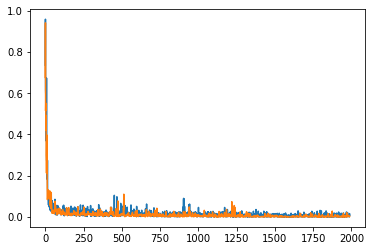

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(losses)
plt.plot(test_losses)
plt.show()

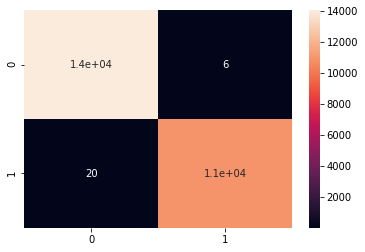

In [40]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_Y[0:25000], dd)
sns.heatmap(cm, annot=True)